In [2]:
import re # regex
from urllib.parse import urlparse
import numpy as np
import pandas as pd

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, roc_curve, confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance

from tld import get_tld, is_tld

ModuleNotFoundError: No module named 'xgboost'

In [4]:
raw = pd.read_csv("./malicious_phish.csv")
raw.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


# EDA 📚

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [6]:
# raw['type'] = raw['type'].astype('category') 
raw['url_type'] = raw['type'].map({'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}).astype(np.int64)
raw.sample(5)

,url,type,url_type
601339,nafso.org.uk/plesk-stat/webscr/Thanks.php,benign,0
431777,cafepress.com/+skeleton+sweatshirts-hoodies,benign,0
33990,brockdavis.tumblr.com/,benign,0
57622,http://www.sanmarinosposi.com/index.php?option...,defacement,1
183674,http://xhamster.com/movies/4573518/sekretaerin...,benign,0


C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\4253660899.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=raw, x=raw.type, palette='tab20', width=.6, order=raw.type.value_counts().index)


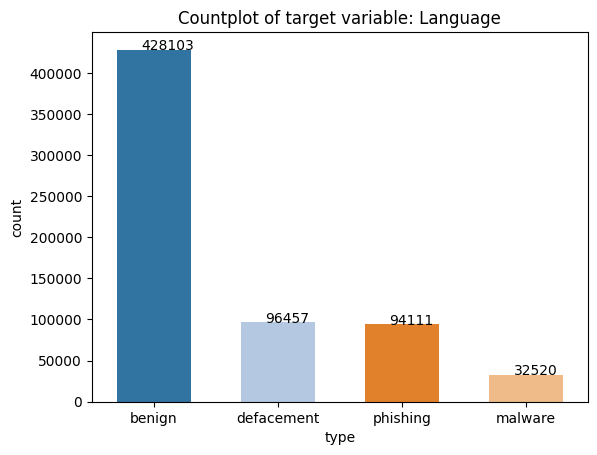

In [7]:
# Countplot
ax = sns.countplot(data=raw, x=raw.type, palette='tab20', width=.6, order=raw.type.value_counts().index)

for p, label in zip(ax.patches, raw.type.value_counts()):
    ax.annotate(label, (p.get_x() + .20, p.get_height() + 1))
ax.set_title('Countplot of target variable: Language')
plt.show()

In [8]:
def process_tld(url):
    try:
        res = get_tld(url, as_object=True, fail_silently=False, fix_protocol=True)
        domain = res.parsed_url.netloc
    except :
        domain = None
    return domain

In [9]:
# *** omit the (www.) from the URL which is in fact a sub domain in itself. ***
raw['url'] = raw['url'].replace('www', '', regex=True)
raw['url_length'] = raw['url'].apply(len)
raw['domain'] = raw['url'].apply(lambda x: process_tld(x))
raw.sample(10)

,url,type,url_type,url_length,domain
315640,profilecanada.com/companydetail.cfm?company=24...,benign,0,97,profilecanada.com
184508,motorcyclistonline.com/2010/flyscooters/hero/0...,benign,0,58,motorcyclistonline.com
116566,qmcecs.wordpress.com/,benign,0,21,qmcecs.wordpress.com
244620,yell.com/s/nurses+agencies+and+care+agencies-k...,benign,0,59,yell.com
186575,ww2incolor.com/canada/SOUVANIER.html,benign,0,36,ww2incolor.com
160242,youtube.com/watch?v=9Hrj3LoriJg,benign,0,31,youtube.com
366443,rhapsody.com/artist/john-kander-and-fred-ebb/a...,benign,0,56,rhapsody.com
50769,gohatters.com/SportSelect.dbml?DB_OEM_ID=14600...,benign,0,68,gohatters.com
159694,punq.org/videos/2007/11/18/unintentionally-iro...,benign,0,115,punq.org
204767,kansas.sportsvite.com/sports/IceHockey,benign,0,38,kansas.sportsvite.com


In [10]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    raw[a] = raw['url'].apply(lambda i: i.count(a))
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [11]:
def abnormal_url(url: str) -> int:
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [12]:
raw['abnormal_url'] = raw['url'].apply(lambda x: abnormal_url(x))

In [13]:
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1


C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\3172289700.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


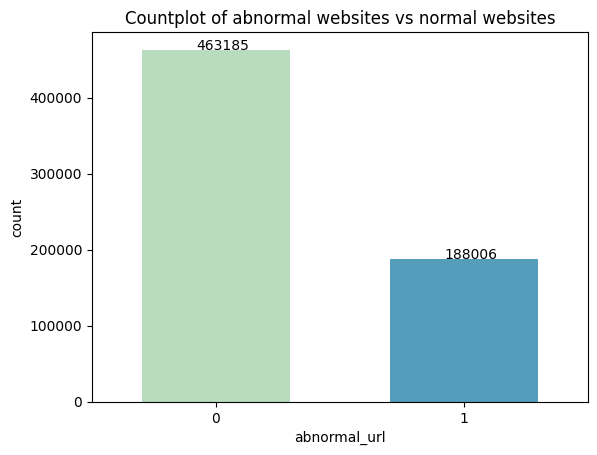

In [14]:
ax = sns.countplot(
    data=raw, x=raw.abnormal_url, palette='GnBu',width=.6, order=raw.abnormal_url.value_counts().index)

for p, label in zip(ax.patches, raw.abnormal_url.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of abnormal websites vs normal websites')
plt.show()

In [15]:
def httpSecured(url: str) -> int:
    htp = urlparse(url).scheme
    match = str(htp)
    if match == 'https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


In [16]:
raw['https'] = raw['url'].apply(lambda x: httpSecured(x))
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,0,0,0,0,0,0,0,1,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1,1,0


C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\1589682235.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=raw, x=raw.https, palette='GnBu',width=.6, order=raw.https.value_counts().index)


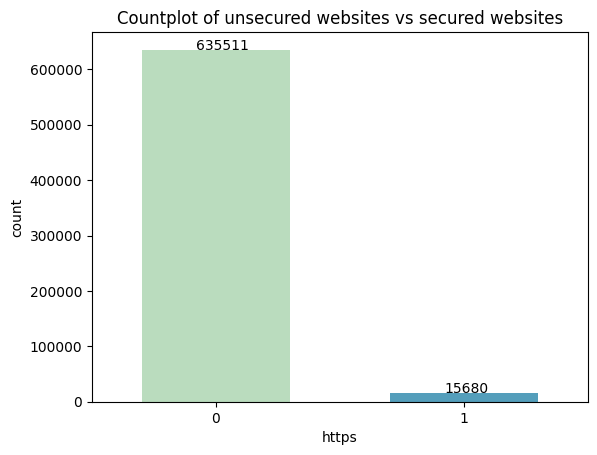

In [17]:
ax = sns.countplot(data=raw, x=raw.https, palette='GnBu',width=.6, order=raw.https.value_counts().index)

for p, label in zip(ax.patches, raw.https.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of unsecured websites vs secured websites')
plt.show()

In [18]:
def digit_count(url: str) -> int:
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

# Counts the number of letter characters in a URL
def letter_count(url: str) -> int:
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [19]:
raw['digits']  = raw['url'].apply(lambda x: digit_count(x))
raw['letters'] = raw['url'].apply(lambda x: letter_count(x))

In [20]:
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,25
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,...,0,0,0,0,0,1,1,0,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,0,1,1,0,22,199


In [21]:
raw.sample(10)

,url,type,url_type,url_length,domain,@,?,-,=,.,...,+,$,!,*,",",//,abnormal_url,https,digits,letters
423057,isthisyour.name/directory/fullnames/ma~westove...,benign,0,51,isthisyour.name,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,45
448356,http://bdnews24.com/bangladesh/2015/05/14/indi...,benign,0,85,bdnews24.com,0,0,6,0,1,...,0,0,0,0,0,1,1,0,10,60
389625,cairs.michaelgeist.ca/content/various-departme...,benign,0,71,cairs.michaelgeist.ca,0,0,7,0,2,...,0,0,0,0,0,0,0,0,16,44
471163,myspace.com/thekingoffrance,benign,0,27,myspace.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,25
313614,http://.smalbro.dk/free-postcards-41-50/1254-f...,defacement,1,80,.smalbro.dk,0,0,9,0,2,...,0,0,0,0,0,1,1,0,11,53
53855,nhl.com/ice/player.htm?id=8462063,benign,0,33,nhl.com,0,1,0,1,2,...,0,0,0,0,0,0,0,0,7,20
334025,http://conservativetribune.com/breaking-us-sen...,benign,0,102,conservativetribune.com,0,0,10,0,1,...,0,0,0,0,0,1,1,0,0,86
545336,https://onedrive.live.com/download?cid=72EF66C...,malware,2,106,onedrive.live.com,0,1,0,3,2,...,0,0,1,0,0,1,1,1,24,69
25220,woulfefamily.com/ardagh_limerick_woulfes,benign,0,40,woulfefamily.com,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,36
330614,greatschools.org/missouri/kansas-city/968-Fore...,benign,0,67,greatschools.org,0,0,4,0,1,...,0,0,0,0,0,0,0,0,3,55


In [22]:
# ** Checks to see whether URL contains a shortening service **
def shortening_service(url: str) -> int:
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:6: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:8: SyntaxWarning: invalid escape sequence '\.'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\3868029804.py:3: SyntaxWarning: invalid escape sequence '\.'
  match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl

In [23]:
raw['shortening_service'] = raw['url'].apply(lambda x: shortening_service(x))
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,...,$,!,*,",",//,abnormal_url,https,digits,letters,shortening_service
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,0,13,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,0,1,29,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,0,1,25,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,...,0,0,0,0,1,1,0,7,60,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,0,1,1,0,22,199,0


C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\3632997411.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


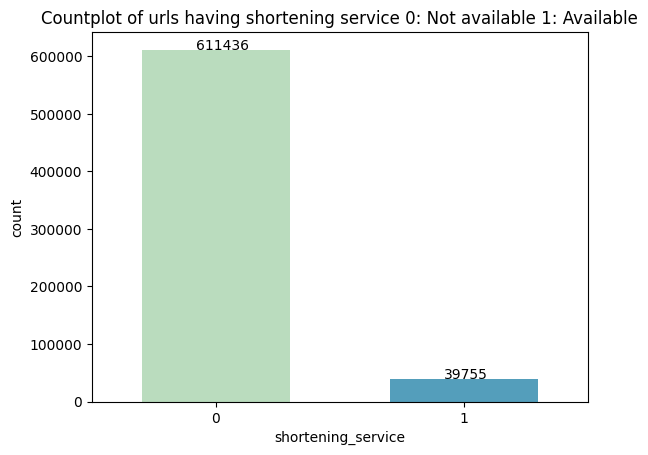

In [24]:
ax = sns.countplot(
    data=raw, 
    x=raw.shortening_service, 
    palette='GnBu',
    width=.6,
    order=raw.shortening_service.value_counts().index)

for p, label in zip(ax.patches, raw.shortening_service.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having shortening service 0: Not available 1: Available')
plt.show()

In [25]:
def having_ip_address(url: str) -> int:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\1036678050.py:9: SyntaxWarning: invalid escape sequence '\.'
  '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\1036678050.py:10: SyntaxWarning: invalid escape sequence '\d'
  '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6


In [26]:
raw['has_ip_address'] = raw['url'].apply(lambda x: having_ip_address(x))
raw.has_ip_address.value_counts()

has_ip_address
0    638703
1     12488
Name: count, dtype: int64

C:\Users\Kaculoss\AppData\Local\Temp\ipykernel_24064\598398006.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


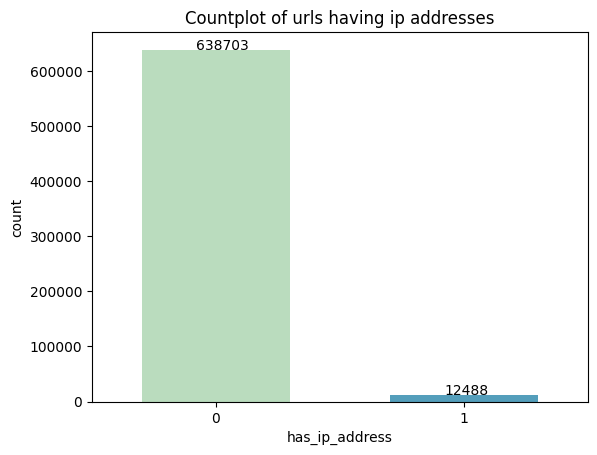

In [27]:
ax = sns.countplot(
    data=raw, 
    x=raw.has_ip_address, 
    palette='GnBu',
    width=.6,
    order=raw.has_ip_address.value_counts().index)

for p, label in zip(ax.patches, raw.has_ip_address.value_counts()):
    ax.annotate(label, (p.get_x() + .22, p.get_height() + 1))
ax.set_title('Countplot of urls having ip addresses')
plt.show()

In [28]:
# - how long exactly these phishing or malicious links are as a string, [to see any pattern]
# raw[raw['type'] == 'phishing'][['url', 'url_length']].describe().T
# raw[raw['type'] == 'malware'][['url', 'url_length']].describe().T
# raw[raw['type'] == 'benign'][['url', 'url_length']].describe().T

# Correlation Plot: HeatMap 📍

In [29]:
raw.head()

,url,type,url_type,url_length,domain,@,?,-,=,.,...,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,br-icloud.com.br,phishing,3,16,br-icloud.com.br,0,0,1,0,2,...,0,0,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,...,0,0,0,0,0,0,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,...,0,0,0,0,0,0,1,25,0,0
3,http://.garage-pirenne.be/index.php?option=com...,defacement,1,85,.garage-pirenne.be,0,1,1,4,3,...,0,0,0,1,1,0,7,60,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,...,0,0,0,1,1,0,22,199,0,0


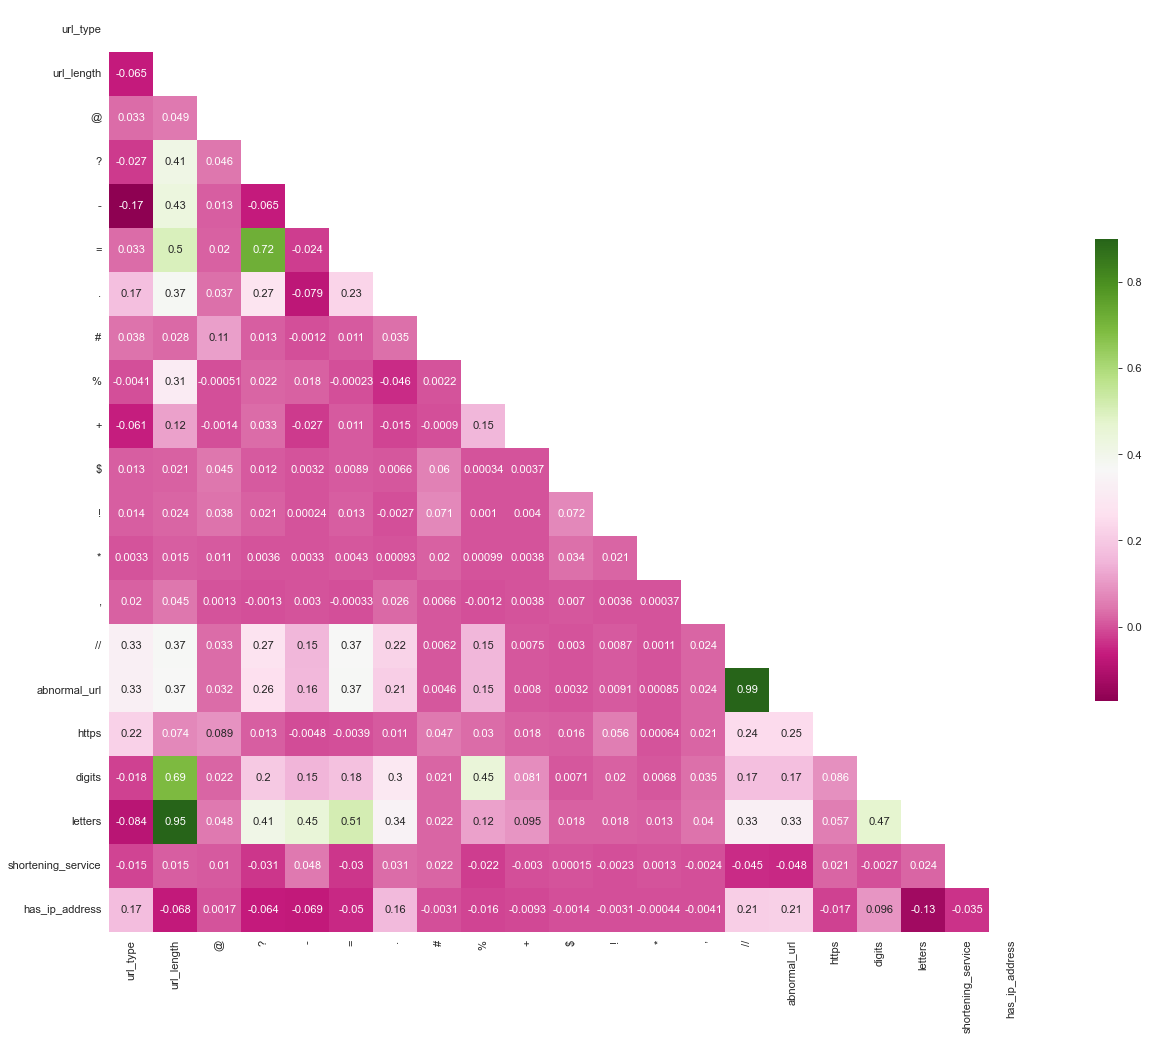

In [30]:
# Assuming raw is your DataFrame
numeric_cols = [col for col in raw.columns if raw[col].dtype in ['int64', 'float64']]
corr = raw[numeric_cols].corr()

# Create the mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 15), dpi=80)

# Draw the heatmap with the mask and correct aspect ratio
sns.set_style('whitegrid') # I like heatmap on a white background
sns.heatmap(corr, mask=mask, square=True, annot=True, vmax=.9, cmap='PiYG', cbar_kws={"shrink": .5})

plt.grid(False)
plt.show()

In [31]:
# - features to remove
# url, type, domain
# - features to keep for model training
# numeric_cols, url_type <- target variable

target = raw[numeric_cols].pop('url_type')
inputs = raw[numeric_cols].drop(columns='url_type', axis=1)

In [32]:
scaler = StandardScaler().fit(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()] = scaler.transform(raw[inputs.columns.to_list()])
raw[inputs.columns.to_list()]

,url_length,@,?,-,=,.,#,%,+,$,!,*,",",//,abnormal_url,https,digits,letters,shortening_service,has_ip_address
0,-0.977485,-0.040954,-0.507190,-0.185091,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-1.007653,-0.254988,-0.139829
1,-0.551230,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.498432,-0.254988,-0.139829
2,-0.640968,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.386931,-0.625737,-0.254988,-0.139829
3,0.570493,-0.040954,1.759256,-0.185091,2.238780,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,0.125854,0.488186,-0.254988,-0.139829
4,3.935662,-0.040954,1.759256,-0.185091,1.579567,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,1.529649,1.569609,-0.157077,1.407817,4.912049,-0.254988,-0.139829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,0.539700,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.553175,-0.753042,-0.254988,-0.139829
651187,-0.349320,-0.040954,-0.507190,0.151181,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,0.125854,-0.498432,3.921747,-0.139829
651188,-0.461492,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.216003,-0.466605,3.921747,-0.139829
651189,-0.326886,-0.040954,-0.507190,-0.521362,-0.398075,-0.131112,-0.026935,-0.116422,-0.110147,-0.01011,-0.024114,-0.005267,-0.031644,-0.633895,-0.637101,-0.157077,-0.472396,-0.275647,-0.254988,-0.139829


In [33]:
raw_sampled = raw[numeric_cols].sample(n=70_000)
raw_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70000 entries, 222985 to 59142
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url_type            70000 non-null  int64  
 1   url_length          70000 non-null  float64
 2   @                   70000 non-null  float64
 3   ?                   70000 non-null  float64
 4   -                   70000 non-null  float64
 5   =                   70000 non-null  float64
 6   .                   70000 non-null  float64
 7   #                   70000 non-null  float64
 8   %                   70000 non-null  float64
 9   +                   70000 non-null  float64
 10  $                   70000 non-null  float64
 11  !                   70000 non-null  float64
 12  *                   70000 non-null  float64
 13  ,                   70000 non-null  float64
 14  //                  70000 non-null  float64
 15  abnormal_url        70000 non-null  float64
 16  http

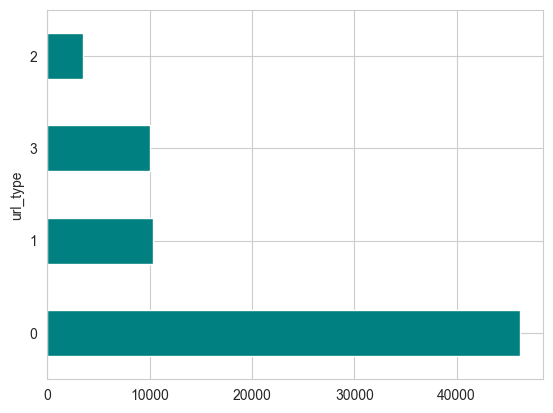

In [34]:
raw_sampled.url_type.value_counts().plot.barh(color='teal');

In [35]:
train_inputs, test_inputs, train_target, test_target = split(
    raw_sampled[inputs.columns], raw_sampled.url_type, test_size=.40, stratify=raw_sampled.url_type, random_state=42)
print(
    f"Train shape: {train_inputs.shape} | Target shape: {train_target.shape}", 
    f"Test shape: {test_inputs.shape} | Test target shape: {test_target.shape}", 
    sep="\n",
)

Train shape: (42000, 20) | Target shape: (42000,)
Test shape: (28000, 20) | Test target shape: (28000,)


# Features Selection 👾

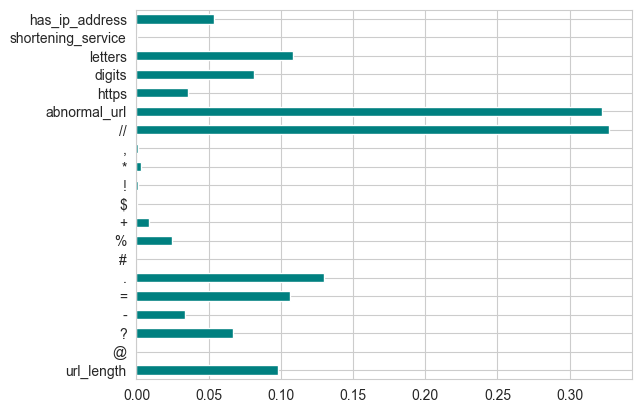

In [36]:
importances = mutual_info_classif(train_inputs, train_target)
feat_importances = pd.Series(importances, train_inputs.columns)
feat_importances.plot(kind='barh', color='teal');

In [37]:
# has_ip_add, letters, digits, abnormal_rul, //, ., =, ?, url_length

# Experiments

In [38]:
def train(model, X, y, average: str = 'macro') -> None:
    preds = model.predict(X)
    metric_summary(y, preds, average)
    
def metric_summary(y, preds, average) -> None:
    acc = accuracy_score(y, preds)
    f1 = f1_score(y, preds, average=average)
    rcl = recall_score(y, preds, average=average)
    print(
        f"Accuracy: {(acc * 100):.2f} %", 
        f"f1: {f1:.2f}", 
        f"recall: {rcl:.2f}", sep="\n"
    )

In [39]:
rffst = RandomForestClassifier(random_state=42).fit(train_inputs, train_target)
train(model=rffst, X=test_inputs, y=test_target)

Accuracy: 90.56 %
f1: 0.86
recall: 0.85


In [40]:
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(start=10, stop=110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf  = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

random_grid = {
    'n_estimators': n_estimators, 
    'max_features': max_features, 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split, 
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap,
    'criterion': criterion,
}

rf_ = RandomForestClassifier()

rf_cv = RandomizedSearchCV(
    estimator=rf_, 
    param_distributions=random_grid, 
    n_iter=5, 
    cv=3, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)

rf_cv.fit(train_inputs, train_target)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [41]:
print(rf_cv.best_params_)

{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': True}


In [42]:
def test_params(model, average: str='macro', **params) -> None:
    model = model(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_target)
    train(model, test_inputs, test_target, average)
    return

In [43]:
test_params(
    model=RandomForestClassifier,
    n_estimators=200, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2',
    max_depth=50, 
    criterion='gini', 
    bootstrap=True,
)

Accuracy: 89.83 %
f1: 0.84
recall: 0.82


In [44]:
test_params(
    model=XGBClassifier,
    n_estimators=200, 
    min_samples_split=10, 
    min_samples_leaf=2, 
    max_features='log2',
    max_depth=50, 
    criterion='gini', 
    bootstrap=True,
    average='weighted',
)

C:\Users\Kaculoss\Desktop\Workspace\malicious url\malicious_url_detection\mudenv\Lib\site-packages\xgboost\core.py:160: UserWarning: [06:18:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "bootstrap", "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 90.36 %
f1: 0.90
recall: 0.90


In [45]:
test_params(
    model=XGBClassifier,
    n_estimators=200, 
    max_depth=50,
    average='weighted',
)

Accuracy: 90.36 %
f1: 0.90
recall: 0.90


***** lg *****


C:\Users\Kaculoss\Desktop\Workspace\malicious url\malicious_url_detection\mudenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy :  82.55%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18457
           1       0.78      0.95      0.86      4127
           2       0.84      0.70      0.76      1406
           3       0.51      0.07      0.13      4010

    accuracy                           0.83     28000
   macro avg       0.74      0.67      0.66     28000
weighted avg       0.79      0.83      0.78     28000

             Confusion_matrix 


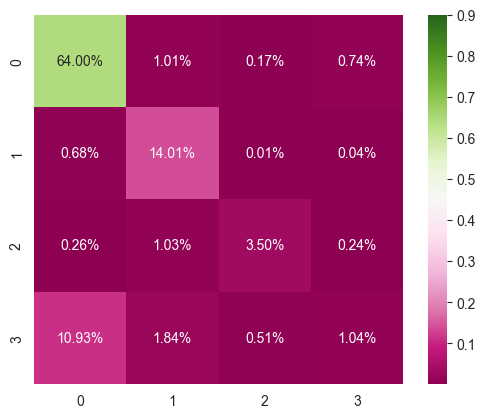

********************** END **********************
***** lgcv *****


C:\Users\Kaculoss\Desktop\Workspace\malicious url\malicious_url_detection\mudenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Kaculoss\Desktop\Workspace\malicious url\malicious_url_detection\mudenv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alterna

Test Accuracy :  82.51%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     18457
           1       0.78      0.95      0.86      4127
           2       0.84      0.69      0.76      1406
           3       0.49      0.08      0.13      4010

    accuracy                           0.83     28000
   macro avg       0.74      0.67      0.66     28000
weighted avg       0.78      0.83      0.78     28000

             Confusion_matrix 


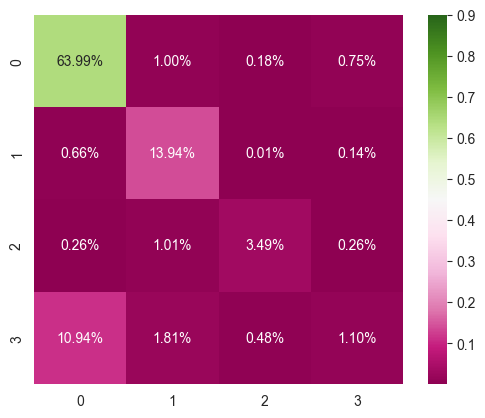

********************** END **********************
***** tree *****
Test Accuracy :  89.15%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18457
           1       0.90      0.92      0.91      4127
           2       0.86      0.84      0.85      1406
           3       0.69      0.62      0.65      4010

    accuracy                           0.89     28000
   macro avg       0.85      0.83      0.84     28000
weighted avg       0.89      0.89      0.89     28000

             Confusion_matrix 


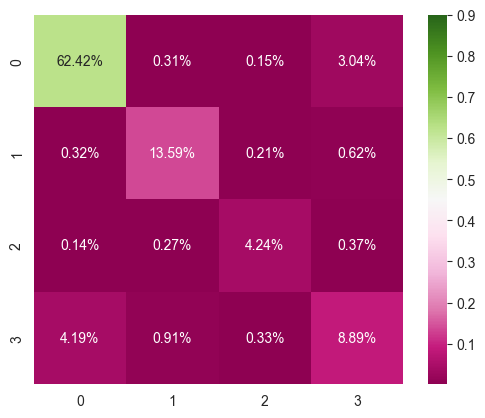

********************** END **********************
***** forest *****
Test Accuracy :  90.59%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     18457
           1       0.91      0.94      0.92      4127
           2       0.93      0.85      0.89      1406
           3       0.74      0.64      0.69      4010

    accuracy                           0.91     28000
   macro avg       0.88      0.85      0.86     28000
weighted avg       0.90      0.91      0.90     28000

             Confusion_matrix 


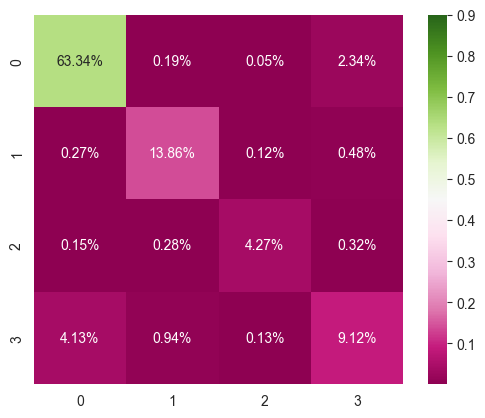

********************** END **********************
***** extas *****
Test Accuracy :  90.49%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     18457
           1       0.91      0.94      0.92      4127
           2       0.93      0.85      0.89      1406
           3       0.74      0.63      0.68      4010

    accuracy                           0.90     28000
   macro avg       0.88      0.84      0.86     28000
weighted avg       0.90      0.90      0.90     28000

             Confusion_matrix 


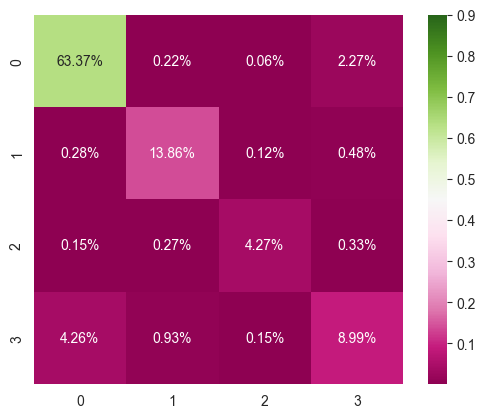

********************** END **********************
***** xgb *****
Test Accuracy :  89.66%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     18457
           1       0.89      0.96      0.92      4127
           2       0.94      0.82      0.88      1406
           3       0.75      0.55      0.63      4010

    accuracy                           0.90     28000
   macro avg       0.87      0.82      0.84     28000
weighted avg       0.89      0.90      0.89     28000

             Confusion_matrix 


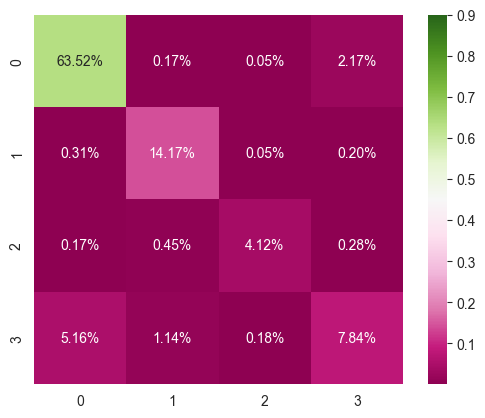

********************** END **********************


In [46]:
test_accuracies = list()
estimators = [
    {"name": "lg", "model": LogisticRegression()}, 
    {"name": "lgcv", "model": LogisticRegressionCV()}, 
    {"name": "tree", "model": DecisionTreeClassifier()}, 
    {"name": "forest", "model": RandomForestClassifier()}, 
    {"name": "extas", "model": ExtraTreesClassifier()}, 
    {"name": "xgb", "model": XGBClassifier()},
]

for estimator in estimators:
    name = estimator['name']
    model = estimator['model']
    print(f"***** {name} *****")
    model.fit(train_inputs, train_target)
    preds = model.predict(test_inputs)
    accuracy = accuracy_score(test_target, preds)
    test_accuracies.append(accuracy)
    
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(accuracy * 100))
    print('\033[01m              Classification Report \033[0m')
    print(classification_report(test_target, preds))
    
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(test_target, preds)
    sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, square=True, vmax=.9, fmt='.2%', cmap='PiYG')
    plt.show()
    
    print("********************** END **********************")

# Test Using Feature Selection

In [51]:
drop_cols = ["shortening_service", "https", ",", "*", "!", "$", "+", "%", "#", "-", "@", "url_type" ]

target_2 = raw[numeric_cols].pop('url_type')
inputs_2 = raw[numeric_cols].drop(columns=drop_cols, axis=1)
inputs_2.head()

,url_length,?,=,.,//,abnormal_url,digits,letters,has_ip_address
0,-0.977485,-0.507190,-0.398075,-0.131112,-0.633895,-0.637101,-0.472396,-1.007653,-0.139829
1,-0.551230,-0.507190,-0.398075,-0.131112,-0.633895,-0.637101,-0.386931,-0.498432,-0.139829
2,-0.640968,-0.507190,-0.398075,-0.131112,-0.633895,-0.637101,-0.386931,-0.625737,-0.139829
3,0.570493,1.759256,2.238780,0.539700,1.529649,1.569609,0.125854,0.488186,-0.139829
4,3.935662,1.759256,1.579567,-0.131112,1.529649,1.569609,1.407817,4.912049,-0.139829


In [52]:
scaler_2 = StandardScaler().fit(raw[inputs_2.columns.to_list()])
inputs_2_scale = scaler_2.transform(raw[inputs_2.columns.to_list()])
inputs_2_scale

array([[-0.97748501, -0.50719044, -0.39807463, ..., -0.47239563,
        -1.00765325, -0.13982891],
       [-0.55123026, -0.50719044, -0.39807463, ..., -0.38693142,
        -0.49843154, -0.13982891],
       [-0.64096811, -0.50719044, -0.39807463, ..., -0.38693142,
        -0.62573697, -0.13982891],
       ...,
       [-0.46149242, -0.50719044, -0.39807463, ..., -0.21600301,
        -0.46660518, -0.13982891],
       [-0.32688566, -0.50719044, -0.39807463, ..., -0.47239563,
        -0.27564704, -0.13982891],
       [-0.48392688, -0.50719044, -0.39807463, ..., -0.47239563,
        -0.37112611, -0.13982891]])